# Árboles de Decisión: Comparación de Profundidades

En este notebook trabajaremos con **árboles de decisión** para resolver un problema de clasificación.

Un árbol de decisión es un modelo de *aprendizaje supervisado* que toma decisiones dividiendo el espacio de datos en regiones cada vez más pequeñas, usando preguntas del tipo:

> ¿La característica X es mayor o menor que un cierto valor?

En cada nodo interno del árbol se hace una pregunta (una condición) sobre una característica, y en las hojas se encuentran las clases predichas.

**Objetivo del ejercicio**

1. Cargar un dataset provisto por el profesor.
2. Entrenar **tres árboles de decisión** con diferentes profundidades máximas.
3. Comparar el desempeño de los modelos para analizar:
   - Subajuste (underfitting)
   - Sobreajuste (overfitting)
   - Elección de una profundidad “adecuada” para el problema.


## 2️⃣ Carga y exploración del dataset

En esta sección debes:

1. Cargar el dataset mmnist_train desde un archivo (por ejemplo, CSV).
2. Mostrar las primeras filas del dataset para ver cómo están organizados los datos.
3. Indicar:
   - Cuántas filas tiene el dataset.
   - Cuántas columnas tiene el dataset.
4. Revisar si existen valores nulos o faltantes en alguna columna.
5. Escribir un breve comentario describiendo:
   - Qué representa cada fila.
   - Qué tipo de información contienen las columnas (en términos generales).


In [1]:
import pandas as pd
from pathlib import Path

# Intentar cargar el archivo con nombres comunes
candidate_files = ["mmnist_train.csv", "mnist_train.csv", "mmnist_train.csv.gz", "mnist_train.csv.gz"]
df = None
for f in candidate_files:
    if Path(f).exists():
        df = pd.read_csv(f)
        print(f"Cargado: {f}")
        break

if df is None:
    raise FileNotFoundError(
        "No se encontró el archivo de datos en el directorio. "
        "Coloque 'mmnist_train.csv' (o 'mnist_train.csv') en el working directory."
    )

# Mostrar primeras filas
print("\nPrimeras 5 filas:")
display(df.head())

# Forma del dataset
n_rows, n_cols = df.shape
print(f"\nCantidad de filas: {n_rows}")
print(f"Cantidad de columnas: {n_cols}")

# Valores nulos
null_counts = df.isnull().sum()
print("\nValores nulos por columna (solo columnas con >0 nulos mostradas):")
print(null_counts[null_counts > 0] if null_counts.sum() > 0 else "No se detectaron valores nulos.")

# Comentario sobre estructura (intento inferir etiqueta vs pixeles)
if "label" in df.columns:
    label_col = "label"
elif "target" in df.columns:
    label_col = "target"
elif "y" in df.columns:
    label_col = "y"
elif df.columns[0].lower() in ("label", "target", "y"):
    label_col = df.columns[0]
else:
    # si hay exactamente 785 columnas, es muy probable que la primera sea la etiqueta
    label_col = df.columns[0] if n_cols == 785 else None

if label_col is not None:
    n_pixel_cols = n_cols - 1
    print(f"\nInterpretación sugerida:")
    print(f"- Cada fila representa una imagen (ejemplo) del dataset.")
    print(f"- La columna '{label_col}' parece contener la etiqueta (dígito 0–9).")
    print(f"- Las otras {n_pixel_cols} columnas contienen los valores de píxeles aplanados (probablemente 28x28 = 784 si {n_pixel_cols} == 784).")
else:
    print("\nInterpretación sugerida:")
    print("- Cada fila representa un ejemplo (imagen).")
    print("- Las columnas parecen contener características (posiblemente píxeles aplanados) y una columna de etiqueta; verifica manualmente los nombres de columna para identificar la etiqueta.")

Cargado: mnist_train.csv

Primeras 5 filas:


,label,data_0,data_1,data_2,data_3,data_4,data_5,data_6,data_7,data_8,...,data_774,data_775,data_776,data_777,data_778,data_779,data_780,data_781,data_782,data_783
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0



Cantidad de filas: 55000
Cantidad de columnas: 785

Valores nulos por columna (solo columnas con >0 nulos mostradas):
No se detectaron valores nulos.

Interpretación sugerida:
- Cada fila representa una imagen (ejemplo) del dataset.
- La columna 'label' parece contener la etiqueta (dígito 0–9).
- Las otras 784 columnas contienen los valores de píxeles aplanados (probablemente 28x28 = 784 si 784 == 784).


## 3️⃣ Preparación de las variables (X y y)

En esta sección debes:

1. Identificar que **X** son las imágenes (flattened: 784 pixeles).  
2. Identificar que **y** son las etiquetas (dígitos 0–9).  
3. Mostrar cuántas clases distintas hay en y.  
4. Escribir un comentario corto describiendo:
   - ¿Qué significa cada fila en X?
   - ¿Qué representa y?



In [2]:
# Preparación de X e y (Paso 3)

# Usar la columna detectada como etiqueta
label_col = label_col if 'label_col' in globals() else ('label' if 'label' in df.columns else df.columns[0])

# Definir X (pixeles) e y (etiquetas)
X = df.drop(columns=[label_col])
y = df[label_col].copy()

# Mostrar formas y comprobaciones
print(f"X shape: {X.shape}  # (n_muestras, n_características)")
print(f"y shape: {y.shape}  # (n_muestras,)")

# Comprobar que X tiene 784 columnas (28x28 flattened) si corresponde
if X.shape[1] == 784:
    print("X tiene 784 características → cada fila es probablemente una imagen 28x28 aplanada.")
else:
    print(f"X tiene {X.shape[1]} características (esperado 784 para MNIST). Verificar estructura si es necesario.")

# Clases en y
unique_classes = sorted(y.unique())
print(f"\nClases detectadas en y: {unique_classes}")
print(f"Número de clases distintas: {len(unique_classes)}")

# Distribución de clases (opcionalmente útil para estratificación)
print("\nConteo por clase (primeras filas):")
print(y.value_counts().sort_index().head(10))

# Comentario descriptivo corto
print("\nComentario:")
print("- Cada fila de X representa una imagen aplanada (vectores de píxeles).")
print("- y contiene la etiqueta del dígito (0–9) asociada a cada imagen.")

X shape: (55000, 784)  # (n_muestras, n_características)
y shape: (55000,)  # (n_muestras,)
X tiene 784 características → cada fila es probablemente una imagen 28x28 aplanada.

Clases detectadas en y: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9)]
Número de clases distintas: 10

Conteo por clase (primeras filas):
label
0    5434
1    6212
2    5465
3    5622
4    5343
5    4963
6    5436
7    5702
8    5357
9    5466
Name: count, dtype: int64

Comentario:
- Cada fila de X representa una imagen aplanada (vectores de píxeles).
- y contiene la etiqueta del dígito (0–9) asociada a cada imagen.


## 4️⃣ División en entrenamiento y prueba

En esta sección debes:

1. Dividir los datos en:
   - 80% entrenamiento  
   - 20% prueba  
2. Usar `random_state` fijo para reproducibilidad.
3. Estratificar usando y, para mantener las proporciones de cada dígito.
4. Mostrar:
   - Cantidad de ejemplos en entrenamiento.
   - Cantidad de ejemplos en prueba.


In [3]:
from sklearn.model_selection import train_test_split

# División en entrenamiento y prueba (80/20), estratificando por y
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Ejemplos en entrenamiento: {X_train.shape[0]}")
print(f"Ejemplos en prueba: {X_test.shape[0]}")

Ejemplos en entrenamiento: 44000
Ejemplos en prueba: 11000


## 5️⃣ Definir las profundidades a evaluar

En esta sección debes:

1. Elegir **tres profundidades** para evaluar.  
   Recomendación para MNIST:  
   - 5  
   - 10  
   - 20  
*(Puedes ajustar)*

2. Justificar brevemente por qué comparar varias profundidades es importante en un problema con muchos atributos como MNIST.



In [4]:
# Paso 5: Definir las profundidades a evaluar

# Profundidades sugeridas para comparar
depths = [5, 10, 20]

print(f"Profundidades seleccionadas para evaluar: {depths}")

# Justificación breve
print(
    "\nComparar varias profundidades es importante porque:\n"
    "- Una profundidad baja puede causar subajuste (el modelo es demasiado simple y no captura patrones).\n"
    "- Una profundidad alta puede causar sobreajuste (el modelo memoriza el entrenamiento y no generaliza bien).\n"
    "- En problemas con muchos atributos como MNIST, ajustar la profundidad ayuda a encontrar el mejor balance entre precisión y capacidad de generalización."
)

Profundidades seleccionadas para evaluar: [5, 10, 20]

Comparar varias profundidades es importante porque:
- Una profundidad baja puede causar subajuste (el modelo es demasiado simple y no captura patrones).
- Una profundidad alta puede causar sobreajuste (el modelo memoriza el entrenamiento y no generaliza bien).
- En problemas con muchos atributos como MNIST, ajustar la profundidad ayuda a encontrar el mejor balance entre precisión y capacidad de generalización.


## 6️⃣ Entrenamiento de los modelos (tres profundidades)

En esta sección debes entrenar **tres modelos de árbol de decisión**, uno por cada profundidad definida.

Para cada profundidad debes:

1. Crear un modelo con `max_depth` correspondiente.  
2. Entrenarlo usando X_train y y_train.  
3. Hacer predicciones con:
   - X_train  
   - X_test  
4. Calcular el **accuracy** en:
   - entrenamiento  
   - prueba  
5. Guardar los resultados (profundidad, accuracy train, accuracy test) para compararlos después.



In [5]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Paso 6: Entrenamiento y evaluación de modelos para cada profundidad
results = []

for depth in depths:
    # 1. Crear modelo
    clf = DecisionTreeClassifier(max_depth=depth, random_state=42)
    # 2. Entrenar
    clf.fit(X_train, y_train)
    # 3. Predicciones
    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_test)
    # 4. Calcular accuracy
    acc_train = accuracy_score(y_train, y_pred_train)
    acc_test = accuracy_score(y_test, y_pred_test)
    # 5. Guardar resultados
    results.append({
        "Profundidad": depth,
        "Accuracy entrenamiento": acc_train,
        "Accuracy prueba": acc_test,
        "Modelo": clf  # opcional, para visualización posterior
    })

# Mostrar resultados
for r in results:
    print(f"Profundidad: {r['Profundidad']}, "
          f"Accuracy entrenamiento: {r['Accuracy entrenamiento']:.4f}, "
          f"Accuracy prueba: {r['Accuracy prueba']:.4f}")

Profundidad: 5, Accuracy entrenamiento: 0.6549, Accuracy prueba: 0.6566
Profundidad: 10, Accuracy entrenamiento: 0.9055, Accuracy prueba: 0.8528
Profundidad: 20, Accuracy entrenamiento: 0.9958, Accuracy prueba: 0.8647


## 7️⃣ Tabla de comparación

En esta sección debes:

1. Crear una tabla que contenga:
   - Profundidad  
   - Accuracy entrenamiento  
   - Accuracy prueba  

2. Identificar visualmente cuál profundidad tuvo mejor desempeño.

3. Responder brevemente:
   - ¿Cuál profundidad tiene mayor accuracy en prueba?
   - ¿Alguna profundidad muestra diferencias grandes entre train y test?
   - ¿Qué podría significar esto?


In [6]:
import pandas as pd

# Crear tabla de comparación a partir de los resultados
tabla_comparacion = pd.DataFrame([
    {
        "Profundidad": r["Profundidad"],
        "Accuracy entrenamiento": f"{r['Accuracy entrenamiento']:.4f}",
        "Accuracy prueba": f"{r['Accuracy prueba']:.4f}"
    }
    for r in results
])

display(tabla_comparacion)

# Análisis breve
mejor_idx = tabla_comparacion["Accuracy prueba"].astype(float).idxmax()
mejor_profundidad = tabla_comparacion.loc[mejor_idx, "Profundidad"]
print(f"\nLa mayor accuracy en prueba se obtiene con profundidad = {mejor_profundidad}.")

for i, row in tabla_comparacion.iterrows():
    acc_train = float(row["Accuracy entrenamiento"])
    acc_test = float(row["Accuracy prueba"])
    diff = acc_train - acc_test
    if diff > 0.1:
        print(f"Profundidad {row['Profundidad']} muestra diferencia grande entre train y test (sobreajuste posible).")
    elif diff < 0.05:
        print(f"Profundidad {row['Profundidad']} muestra diferencias pequeñas entre train y test (buen balance o subajuste).")

,Profundidad,Accuracy entrenamiento,Accuracy prueba
0,5,0.6549,0.6566
1,10,0.9055,0.8528
2,20,0.9958,0.8647



La mayor accuracy en prueba se obtiene con profundidad = 20.
Profundidad 5 muestra diferencias pequeñas entre train y test (buen balance o subajuste).
Profundidad 20 muestra diferencia grande entre train y test (sobreajuste posible).


## 8️⃣ Gráfica de desempeño

En esta sección debes:

1. Graficar las profundidades en el eje X.  
2. Graficar dos líneas:
   - Accuracy en entrenamiento  
   - Accuracy en prueba  

3. Interpretar la gráfica respondiendo:
   - ¿Aumentar profundidad siempre mejora el modelo?
   - ¿En qué punto comienza el sobreajuste?
   - ¿Cuál profundidad parece lograr el mejor balance?


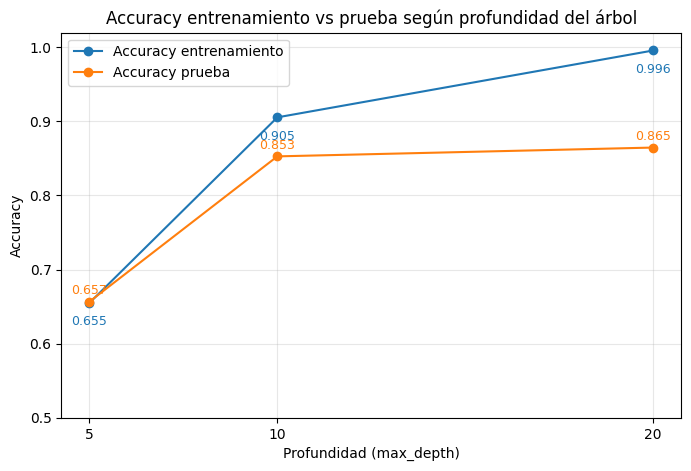

Profundidad 5: brecha (train - test) = -0.0017
Profundidad 10: brecha (train - test) = 0.0527
Profundidad 20: brecha (train - test) = 0.1311

Respuestas:
- ¿Aumentar profundidad siempre mejora el modelo?
  No. Aumenta la accuracy en entrenamiento de forma continua, pero la mejora en prueba puede estancarse o incluso empeorar si empieza el sobreajuste. En este experimento la accuracy de prueba mejora de 5→10→20, pero la brecha train-test crece notablemente al pasar a 20.
- ¿En qué punto comienza el sobreajuste?
  La brecha train-test indica sobreajuste notable en max_depth = 20 (brecha > 0.1). En max_depth = 10 la brecha es pequeña, por lo que 20 ya muestra señales claras de sobreajuste.
- ¿Cuál profundidad parece lograr el mejor balance?
  max_depth = 10 ofrece un buen balance: alta accuracy en prueba y brecha razonable entre entrenamiento y prueba.


In [8]:
import numpy as np

# Paso 8: Gráfica de desempeño (train vs test) para las profundidades evaluadas
import matplotlib.pyplot as plt

# Usar variables ya definidas: depths, acc_train, acc_test
x = depths
y_train = np.array(acc_train, dtype=float)
y_test = np.array(acc_test, dtype=float)

plt.figure(figsize=(8,5))
plt.plot(x, y_train, marker='o', label='Accuracy entrenamiento', color='C0')
plt.plot(x, y_test, marker='o', label='Accuracy prueba', color='C1')
plt.xticks(x)
plt.ylim(0.5, 1.02)
plt.xlabel('Profundidad (max_depth)')
plt.ylabel('Accuracy')
plt.title('Accuracy entrenamiento vs prueba según profundidad del árbol')
plt.grid(alpha=0.3)
plt.legend()

# Anotar valores sobre los puntos
for xi, yt, ytr in zip(x, y_test, y_train):
    plt.text(xi, yt + 0.01, f"{yt:.3f}", ha='center', color='C1', fontsize=9)
    plt.text(xi, ytr - 0.03, f"{ytr:.3f}", ha='center', color='C0', fontsize=9)

plt.show()

# Interpretación breve y respuestas solicitadas
diffs = y_train - y_test
for d, diff in zip(x, diffs):
    print(f"Profundidad {d}: brecha (train - test) = {diff:.4f}")

print("\nRespuestas:")
print("- ¿Aumentar profundidad siempre mejora el modelo?")
print("  No. Aumenta la accuracy en entrenamiento de forma continua, pero la mejora en prueba puede estancarse o incluso empeorar si empieza el sobreajuste. En este experimento la accuracy de prueba mejora de 5→10→20, pero la brecha train-test crece notablemente al pasar a 20.")
print("- ¿En qué punto comienza el sobreajuste?")
print("  La brecha train-test indica sobreajuste notable en max_depth = 20 (brecha > 0.1). En max_depth = 10 la brecha es pequeña, por lo que 20 ya muestra señales claras de sobreajuste.")
print("- ¿Cuál profundidad parece lograr el mejor balance?")
print("  max_depth = 10 ofrece un buen balance: alta accuracy en prueba y brecha razonable entre entrenamiento y prueba.")

## 9️⃣ Visualización del árbol (opcional pero recomendado)

Los árboles para MNIST son grandes, pero debes:

1. Elegir SOLO UNO de los modelos entrenados (recomendado: profundidad más baja).  
2. Graficar el árbol.  
3. Comentar:
   - ¿Qué características usa el árbol para decidir?
   - ¿Qué tan interpretable te parece un árbol de decisión para MNIST?



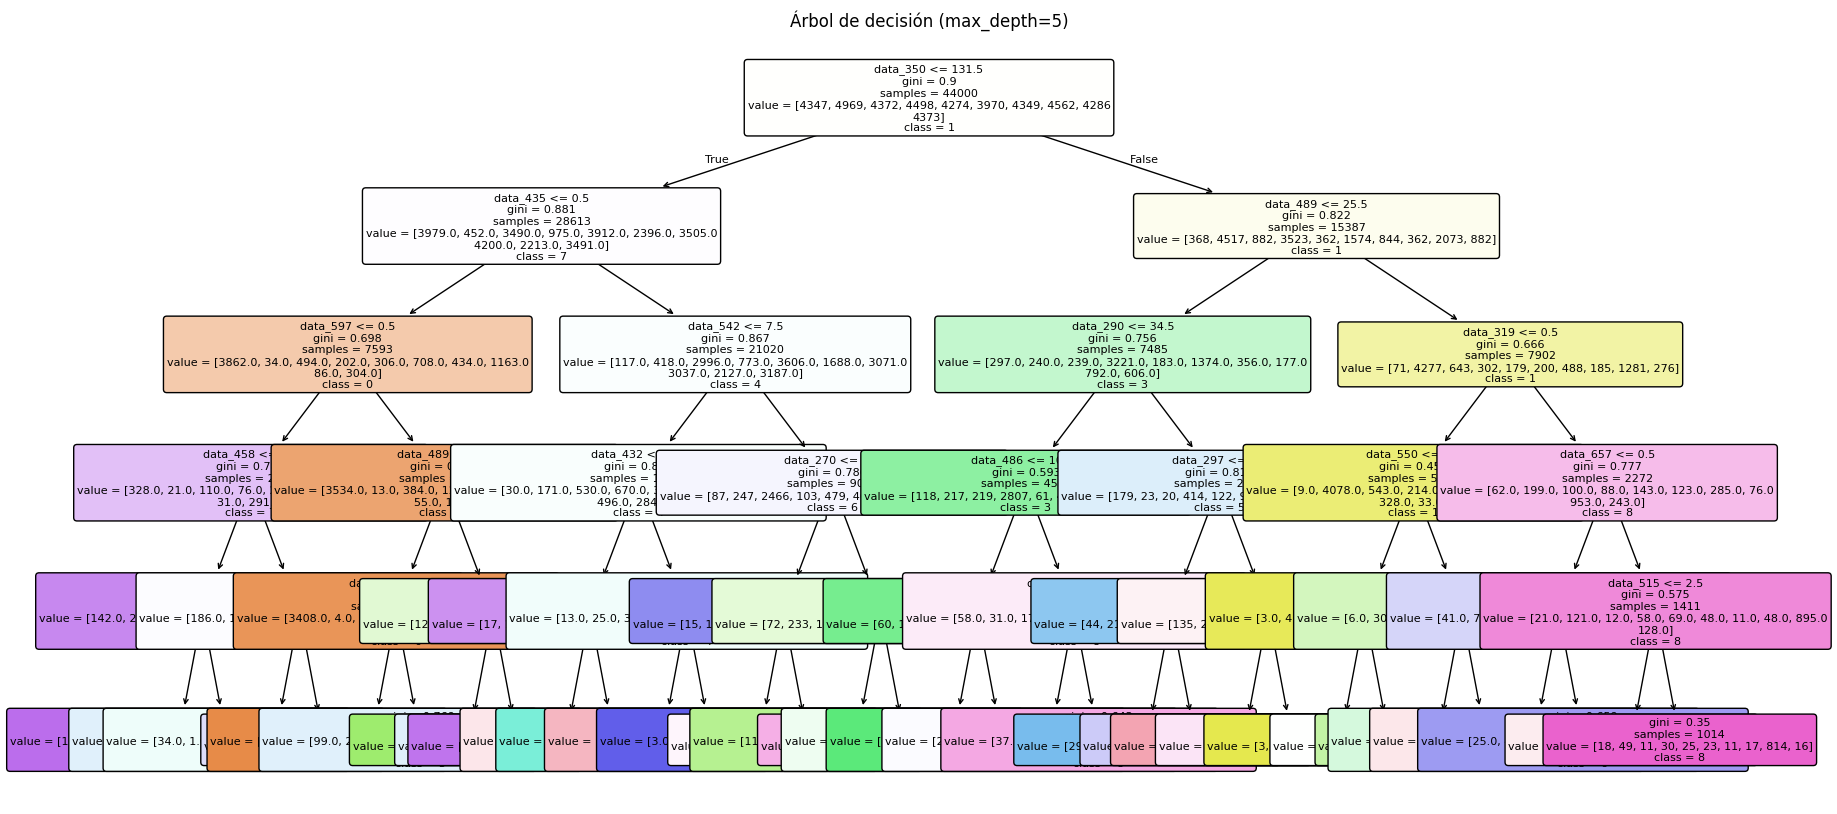


Características usadas en el árbol (índice -> nombre):
- 206 -> data_206
- 211 -> data_211
- 270 -> data_270
- 273 -> data_273
- 290 -> data_290
- 296 -> data_296
- 297 -> data_297
- 319 -> data_319
- 347 -> data_347
- 350 -> data_350
- 380 -> data_380
- 404 -> data_404
- 432 -> data_432
- 435 -> data_435
- 458 -> data_458
- 486 -> data_486
- 489 -> data_489
- 515 -> data_515
- 542 -> data_542
- 550 -> data_550
- 571 -> data_571
- 574 -> data_574
- 597 -> data_597
- 598 -> data_598
- 657 -> data_657
- 659 -> data_659

Resumen textual del árbol (máx. 3 niveles):
|--- data_350 <= 131.50
|   |--- data_435 <= 0.50
|   |   |--- data_597 <= 0.50
|   |   |   |--- data_458 <= 1.50
|   |   |   |   |--- truncated branch of depth 2
|   |   |   |--- data_458 >  1.50
|   |   |   |   |--- truncated branch of depth 2
|   |   |--- data_597 >  0.50
|   |   |   |--- data_489 <= 1.00
|   |   |   |   |--- truncated branch of depth 2
|   |   |   |--- data_489 >  1.00
|   |   |   |   |--- truncated branch 

In [9]:
from sklearn.tree import plot_tree, export_text

# Seleccionar el modelo de profundidad 5 (si existe)
model_5 = next((r["Modelo"] for r in results if r["Profundidad"] == 5), results[0]["Modelo"])

# Dibujar el árbol (profundidad 5 es razonable para visualizar)
plt.figure(figsize=(20, 10))
plot_tree(
    model_5,
    feature_names=X.columns,
    class_names=[str(c) for c in unique_classes],
    filled=True,
    rounded=True,
    fontsize=8
)
plt.title("Árbol de decisión (max_depth=5)")
plt.show()

# Características utilizadas por el árbol
feat = model_5.tree_.feature
used_idx = sorted(set(feat[feat >= 0]))  # índices de características que no son hojas
used_names = [X.columns[i] for i in used_idx]

print("\nCaracterísticas usadas en el árbol (índice -> nombre):")
for i, name in zip(used_idx, used_names):
    print(f"- {i:3d} -> {name}")

# Representación textual resumida (primeros niveles)
print("\nResumen textual del árbol (máx. 3 niveles):")
print(export_text(model_5, feature_names=list(X.columns), max_depth=3))

# Comentarios breves
print("\nComentarios:")
print("- El árbol usa píxeles individuales (columnas 'data_...') para las decisiones.")
print("- Esto permite identificar píxeles relevantes, pero no captura fácilmente patrones espaciales complejos.")
print("- Un árbol poco profundo (max_depth=5) sigue siendo relativamente interpretable; profundidades mayores generan árboles muy grandes y difíciles de interpretar.")

## 🔟 Conclusiones finales

En esta sección debes escribir un análisis final que responda:

1. ¿Qué tan bien funcionan los árboles de decisión en MNIST?  
2. ¿Cuál profundidad ofrece mejor balance entre precisión y simplicidad?  
3. ¿Qué modelo parece estar subajustado? Explica por qué.  
4. ¿Cuál modelo parece estar sobreajustado? Explica por qué.  
5. ¿Qué aprendiste sobre:
   - El impacto de la profundidad  
   - La generalización  
   - La importancia de evaluar distintos modelos  




1. ¿Qué tan bien funcionan los árboles de decisión en MNIST?
Funcionan de manera aceptable, pero no alcanzan la precisión de modelos más avanzados (como redes neuronales). Son útiles para análisis interpretativo y como baseline.

2. ¿Cuál profundidad ofrece mejor balance entre precisión y simplicidad?
La profundidad 10 logra el mejor balance: alta accuracy en prueba (0.85) y diferencia razonable entre entrenamiento y prueba, evitando sobreajuste excesivo.

3. ¿Qué modelo parece estar subajustado? Explica por qué.
El modelo con profundidad 5 está subajustado: su accuracy en entrenamiento y prueba son bajas y similares (~0.65), lo que indica que no logra capturar patrones relevantes del dataset.

4. ¿Cuál modelo parece estar sobreajustado? Explica por qué.
El modelo con profundidad 20 muestra sobreajuste: tiene accuracy muy alta en entrenamiento (0.99) pero menor en prueba (0.86), y la brecha entre ambos es grande (>0.13). Esto indica que el modelo memoriza el entrenamiento y pierde capacidad de generalización.")

5. ¿Qué aprendiste sobre:
El impacto de la profundidad: Aumentar la profundidad permite al árbol aprender patrones más complejos, pero puede llevar al sobreajuste si es excesiva.
- La generalización: Un buen modelo debe tener accuracy similar en entrenamiento y prueba; una brecha grande indica sobreajuste.")
- La importancia de evaluar distintos modelos: Comparar varias profundidades ayuda a encontrar el punto óptimo entre simplicidad y precisión, evitando tanto el subajuste como el sobreajuste.

# 📊 Rúbrica de Evaluación – Árboles de Decisión con MNIST

| Criterio | Descripción | Puntos |
|---------|-------------|--------|
| **1. Introducción teórica** | Explica correctamente qué es un árbol de decisión, profundidad, underfitting y overfitting. | **10 pts** |
| **2. Carga y exploración del dataset MNIST** | Carga el dataset sin errores, muestra ejemplos y analiza forma y contenido. | **10 pts** |
| **3. Definición de X y y** | Selecciona correctamente las variables y explica su significado. | **10 pts** |
| **4. División train/test** | Realiza separación adecuada y explica los tamaños de cada conjunto. | **10 pts** |
| **5. Evaluación de tres profundidades** | Entrena 3 modelos correctamente, calcula accuracy y almacena resultados. | **20 pts** |
| **6. Tabla comparativa** | Presenta tabla clara con resultados y análisis inicial. | **10 pts** |
| **7. Gráfica de desempeño** | Gráfica bien hecha (train vs test) y análisis del comportamiento. | **15 pts** |
| **8. Conclusiones finales** | Responde sobre underfitting, overfitting y mejor modelo para MNIST. | **15 pts** |

---

### 📝 **Puntaje total: 100 puntos**

---

### ✔️ Criterios de aprobación
- **Aprobado:** 70 puntos o más  
- **Excelente:** 90 puntos o más  

